## Revisit win probability experiments

When I first tried experimenting with predicting win probabilities and measuring the bits metric, I made a lot of mistakes that resulted in zany bits scores for the various models. Now that I've worked out the bugs, it's worth going back and re-running those experiments with the correct bits results.

## Setup

In [1]:
%load_ext autoreload

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
%autoreload 2

from functools import partial
import math

from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, XGBClassifier

import numpy as np
import seaborn as sns
import scipy
import pandas as pd

from augury.ml_data import MLData
from augury.ml_estimators import StackingEstimator, ConfidenceEstimator, base_ml_estimator
from augury.model_tracking import score_model
from augury.settings import TEAM_NAMES, ROUND_TYPES, VENUES, CATEGORY_COLS, CV_YEAR_RANGE, SEED
from augury.sklearn.metrics import bits_scorer, _calculate_bits, bits_objective
from augury.sklearn.model_selection import year_cv_split
from augury.sklearn.models import EloRegressor
from augury.sklearn.preprocessing import ColumnDropper, TeammatchToMatchConverter

np.random.seed(SEED)

N_ROWS_PER_MATCH = 2

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
result_data = MLData(train_year_range=(max(CV_YEAR_RANGE),), label_col='result')
margin_data = MLData(train_year_range=(max(CV_YEAR_RANGE),), label_col='margin')
result_data.data

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-03-01 21:48:17,705 - kedro.io.data_catalog - INFO - Loading data from `full_data` (JSONDataSet)...


team      oppo_team round_type  \
Adelaide         1991 1           Adelaide       Hawthorn    Regular   
                      2           Adelaide        Carlton    Regular   
                      3           Adelaide         Sydney    Regular   
                      4           Adelaide       Essendon    Regular   
                      5           Adelaide     West Coast    Regular   
...                                    ...            ...        ...   
Western Bulldogs 2021 19  Western Bulldogs       Adelaide    Regular   
                      20  Western Bulldogs      Melbourne    Regular   
                      21  Western Bulldogs       Essendon    Regular   
                      22  Western Bulldogs       Hawthorn    Regular   
                      23  Western Bulldogs  Port Adelaide    Regular   

                                   venue prev_match_oppo_team  \
Adelaide         1991 1    Football Park                    0   
                      2    Football Park             Hawthorn   
                      3           S.C.G.              Carlton   
                      4       Windy Hill               Sydney   
                      5          Subiaco             Essendon   
...                                  ...                  ...   
Western Bulldogs 2021 19  Eureka Stadium           Gold Coast   
                      20          M.C.G.             Adelaide   
                      21       Docklands            Melbourne   
                      22       York Park             Essendon   
                      23       Docklands             Hawthorn   

                         oppo_prev_match_oppo_team                      date  \
Adelaide         1991 1                  Melbourne 1991-03-22 03:56:00+00:00   
                      2                    Fitzroy 1991-03-31 03:56:00+00:00   
                      3                   Hawthorn 1991-04-07 03:05:00+00:00   
                      4            North Melbourne 1991-04-13 03:30:00+00:00   
                      5            North Melbourne 1991-04-21 05:27:00+00:00   
...                                            ...                       ...   
Western Bulldogs 2021 19                West Coast 2021-07-24 02:20:00+00:00   
                      20                Gold Coast 2021-07-31 02:20:00+00:00   
                      21                    Sydney 2021-08-07 02:20:00+00:00   
                      22               Collingwood 2021-08-14 02:11:00+00:00   
                      23                   Carlton 2021-08-21 02:20:00+00:00   

                          team_goals  team_behinds  score  ...  \
Adelaide         1991 1           24            11    155  ...   
                      2           12             9     81  ...   
                      3           19            18    132  ...   
                      4            6            11     47  ...   
                      5            9            11     65  ...   
...                              ...           ...    ...  ...   
Western Bulldogs 2021 19           0             0      0  ...   
                      20           0             0      0  ...   
                      21           0             0      0  ...   
                      22           0             0      0  ...   
                      23           0             0      0  ...   

                          oppo_rolling_prev_match_time_on_ground_skew  \
Adelaide         1991 1                                           0.0   
                      2                                           0.0   
                      3                                           0.0   
                      4                                           0.0   
                      5                                           0.0   
...                                                               ...   
Western Bulldogs 2021 19                                          0.0   
                      20                              

In [4]:
# We need to create our own cross_val_predict, because the version from Scikit-Learn
# doesn't permit time-series CV splits
def _make_cv_prediction(estimator, X, y, train, test):
    X_train, y_train = X[train], y[train]
    X_test = X[test]
    estimator.fit(X_train, y_train)
    return estimator.predict(X_test)

def time_series_cross_val_predict(estimator, X, y, cv):
    make_cv_prediction = partial(_make_cv_prediction, estimator, X, y)

    return np.array([make_cv_prediction(train, test) for train, test in cv])

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Test Models

### ConfidenceEstimator

This is the current model used to make win probability predictions.

In [5]:
tipresias_proba = ConfidenceEstimator()

In [6]:
tipresias_scores = score_model(tipresias_proba, result_data, n_jobs=-1, scoring={'bits': bits_scorer})
tipresias_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


{'fit_time': array([105.10931158, 107.21892929, 103.08525348, 108.38244581,
         14.94646168]),
 'score_time': array([0.10475111, 0.0650692 , 0.10036898, 0.01539826, 0.0113008 ]),
 'test_bits': array([ -9.52772771, -13.06468416,  -7.3097688 , -10.06808159,
        -46.2403722 ])}

In [7]:
print('Bits per season:', tipresias_scores['test_bits'].sum() / len(tipresias_scores['test_bits']))

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Bits per season: -17.242126892854166


### Confidence from sampling margin predictions

In [16]:
stacking = StackingEstimator()

sampling_test_year = CV_YEAR_RANGE[1] - 1
sampling_train_year_range = (CV_YEAR_RANGE[0], sampling_test_year)

X_train, y_train = margin_data.train_data
X_val = X_train.query(f'year == {sampling_test_year}')
y_val = y_train.loc[(slice(None), sampling_test_year, slice(None))]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
margin_cv_preds = time_series_cross_val_predict(
    stacking,
    *margin_data.train_data,
    cv=year_cv_split(X_train, CV_YEAR_RANGE)
)

margin_cv_preds

2021-03-01 21:50:40,529 - kedro.io.data_catalog - INFO - Loading data from `full_data` (JSONDataSet)...


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-ca92af5bb448>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([make_cv_prediction(train, test) for train, test in cv])


array([array([ 8.94476744e+00,  3.98546512e+00,  3.56453488e+01,  1.99854651e+01,
        1.74186047e+01,  2.19651163e+01,  5.73517442e+01, -1.27325581e+00,
       -3.09883721e+00,  2.60843023e+01, -1.31860465e+01,  2.85000000e+01,
       -2.78779070e+01, -5.00000000e-01,  5.74273256e+01, -1.59651163e+01,
        1.19069767e+01,  1.62470930e+01,  5.48197674e+01,  4.36627907e+00,
       -6.68604651e-01,  3.23604651e+01, -2.60261628e+01, -1.66569767e+00,
       -2.41773256e+01, -2.51308140e+01, -1.31191860e+01, -3.75872093e+00,
       -1.85116279e+01, -2.32500000e+01, -1.99040698e+01,  2.79796512e+01,
       -3.20552326e+01, -1.92151163e+01, -2.55523256e+01, -5.36046512e+01,
       -3.96627907e+01,  7.56395349e+00, -4.08575581e+01, -4.04563953e+01,
        1.09767442e+01,  3.43313953e+00, -6.31947674e+01, -5.03197674e+01,
       -1.89011628e+01,  6.25000000e-01, -2.93808140e+01, -2.19534884e+01,
        1.68023256e+00, -5.38081395e+00,  9.91569767e+00,  2.41860465e+00,
       -2.73313953

#### Kernel Density Estimation

We can use KernelDensity to generate a distribution based on margin predictions from a regressor. We can then use this distribution to measure the model's confidence that a given team will win its match (i.e. what % of predictions are greater than 0?).

In [10]:
train_preds = np.concatenate(margin_cv_preds[:-1])
test_preds = margin_cv_preds[-1]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

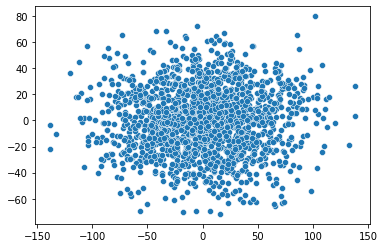

In [17]:
# Scatter of predictions vs results

sns.scatterplot(
    x=y_train.loc[(slice(None), slice(sampling_train_year_range[0], sampling_train_year_range[1] - 1), slice(None))].to_numpy(),
    y=train_preds
)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

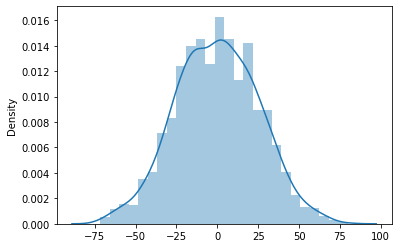

In [18]:
# Histogram of predictions

sns.distplot(train_preds)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

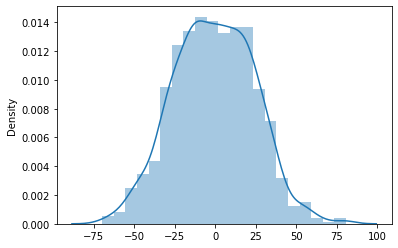

In [19]:
kd = KernelDensity()

kd.fit(train_preds.reshape(-1, 1))
sample = kd.sample(n_samples=1000)

# Histogram of predictions generated from the distribution
sns.distplot(sample.reshape(-1, 1))

In [20]:
print('Mean prediction:', train_preds.mean())
print('Mean prediction from sample:', sample.mean())

Mean prediction: -0.18263922086930445
Mean prediction from sample: -0.7558251122840653


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
print('Std for predictions:', train_preds.std())
print('Std for predictions from sample:', sample.std())

Std for predictions: 25.409055098616896
Std for predictions from sample: 24.79040795631061


In [22]:
kd_confidences = np.array([
    scipy.stats.percentileofscore(sample, pred) / 100
    for pred in test_preds
])

kd_confidences

array([0.67 , 0.517, 0.788, 0.581, 0.933, 0.393, 0.831, 0.528, 0.578,
       0.394, 0.604, 0.592, 0.788, 0.264, 0.825, 0.972, 0.862, 0.899,
       0.957, 0.317, 0.632, 0.417, 0.263, 0.557, 0.68 , 0.481, 0.363,
       0.648, 0.578, 0.522, 0.392, 0.63 , 0.492, 0.849, 0.61 , 0.632,
       0.196, 0.416, 0.748, 0.457, 0.704, 0.997, 0.579, 0.324, 0.985,
       0.972, 0.257, 0.053, 0.114, 0.514, 0.292, 0.086, 0.119, 0.051,
       0.012, 0.21 , 0.313, 0.16 , 0.379, 0.153, 0.338, 0.254, 0.748,
       0.15 , 0.253, 0.058, 0.298, 0.033, 0.823, 0.533, 0.585, 0.677,
       0.554, 0.606, 0.783, 0.953, 0.956, 0.569, 0.96 , 0.749, 0.717,
       0.933, 0.69 , 0.18 , 0.426, 0.488, 0.973, 0.813, 0.356, 0.829,
       0.104, 0.927, 0.516, 0.734, 0.529, 0.555, 0.585, 0.466, 0.229,
       0.617, 0.74 , 0.338, 0.706, 0.633, 0.323, 0.439, 0.674, 0.816,
       0.269, 0.954, 0.883, 0.571, 0.483, 0.227, 0.1  , 0.343, 0.868,
       0.773, 0.107, 0.173, 0.767, 0.15 , 0.648, 0.279, 0.428, 0.06 ,
       0.503, 0.483,

In [35]:
bits = _calculate_bits(y_val, kd_confidences).sum()
bits / N_ROWS_PER_MATCH

-101.83959661544088

### Bootstrapping

In [26]:
BOOTSTRAP_YEAR_RANGE = (1966, sampling_test_year)

def bootstrap_predictions(estimator, X, y, year_range, n_iter=10, one_year=True):
    """Split data by year for cross-validation for time-series data"""

    test_years = np.random.choice(range(*sampling_train_year_range), n_iter)
    preds = []
    
    for year in test_years:
        X_train = X.query('year < @year')
        X_test = X.query('year == @year') if one_year else X.query('year >= @year')
        y_train = y.loc[X_train.index]
        
        boot_estimator = clone(estimator)
        boot_estimator.fit(X_train, y_train)
        preds.append(boot_estimator.predict(X_test))
        
    return np.concatenate(preds)

In [27]:
boot_preds = bootstrap_predictions(stacking, X_train, y_train, BOOTSTRAP_YEAR_RANGE)
boot_preds

array([  8.94476744,   3.98546512,  35.64534884, ..., -33.09883721,
        11.15697674, -41.17732558])

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

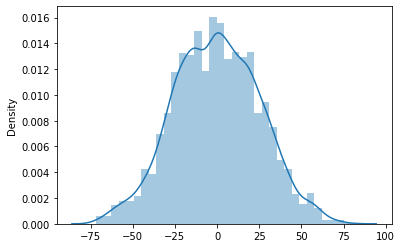

In [28]:
sns.distplot(boot_preds.reshape(-1, 1))

In [29]:
boot_preds.mean(), boot_preds.std()

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.258410054995589, 25.372979401372096)

In [30]:
bs_confidences = np.array([
    scipy.stats.percentileofscore(boot_preds, pred) / 100
    for pred in margin_cv_preds[-1]
])
    
bs_confidences

array([0.66803874, 0.51501211, 0.77772397, 0.58280872, 0.91985472,
       0.38571429, 0.81331719, 0.52130751, 0.58038741, 0.38813559,
       0.60702179, 0.58813559, 0.78305085, 0.26731235, 0.81113801,
       0.96004843, 0.84576271, 0.88571429, 0.93946731, 0.31138015,
       0.63244552, 0.40653753, 0.26368039, 0.55060533, 0.68377724,
       0.4653753 , 0.36343826, 0.65084746, 0.58038741, 0.51985472,
       0.38256659, 0.63075061, 0.49176755, 0.83535109, 0.61428571,
       0.63414044, 0.18958838, 0.40169492, 0.7409201 , 0.44552058,
       0.69878935, 0.99975787, 0.58062954, 0.32009685, 0.98208232,
       0.96246973, 0.25835351, 0.0527845 , 0.11307506, 0.51162228,
       0.2937046 , 0.08668281, 0.11501211, 0.04891041, 0.01864407,
       0.20871671, 0.30677966, 0.15641646, 0.37409201, 0.15181598,
       0.33583535, 0.25714286, 0.74358354, 0.14140436, 0.25375303,
       0.05786925, 0.29830508, 0.03317191, 0.80992736, 0.52760291,
       0.58450363, 0.68087167, 0.54769976, 0.6094431 , 0.77602

In [36]:
bits = _calculate_bits(y_val, bs_confidences).sum()
bits / N_ROWS_PER_MATCH

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-99.9549462987879

### XGBoost

In [40]:
xgbc = make_pipeline(
    base_ml_estimator.BASE_ML_PIPELINE,
    XGBClassifier(
        random_state=SEED,
        verbosity=0,
    ),
)

In [41]:
xgbc_scores = score_model(xgbc, result_data, n_jobs=-1, scoring={'bits': bits_scorer})
xgbc_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.6min finished


{'fit_time': array([416.51529408, 424.04242039, 421.99258065, 421.9609611 ,
         23.70892549]),
 'score_time': array([0.31759024, 0.01759958, 0.15513158, 0.04422712, 0.0122478 ]),
 'test_bits': array([-95.52236703, -94.63192785, -91.71138542, -97.27927473,
        -80.70420222])}

In [42]:
print('Bits per season:', xgbc_scores['test_bits'].sum() / len(xgbc_scores['test_bits']))

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Bits per season: -91.96983144954753


## Conclusion

Bits scores are still garbage even after correcting how they're calculated. I'll go ahead and run the same confidence model that was at least mediocre last year and see how it goes. The experiments this year have revealed some aspects of my data processing that could use improvement to simplify both the pipeline and experimenting with models. Namely, I should index the data, so it's sorted by datetime (or maybe by season, then round number) and reconsider organising rows by team-match (since match rows would be easier to work with, especially when measuring performance).